In [1]:
import numpy as np
import pandas as pd
import torch

import logging
from tqdm import tqdm
import math
import argparse
import os

 #  Load Pretrained model
 Load Pretrained GPT2 model from transformers module

In [2]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

Cloning into 'transformers'...
remote: Enumerating objects: 141326, done.
remote: Counting objects: 100% (1331/1331), done.
remote: Compressing objects: 100% (627/627), done.
remote: Total 141326 (delta 794), reused 1034 (delta 579), pack-reused 139995
Receiving objects: 100% (141326/141326), 139.38 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (105736/105736), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7108038 sha256=158671e7e12cf626a1c9f8e3919067cbbf9634e3b5a669bf7371f6349d4becfc
  Stored in directory: /tmp/pip-ephem

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=88888)
parser.add_argument("--model_name", default="gpt2", type=str)
parser.add_argument("--max_seq_length", default=512, type=int)
parser.add_argument("--train_batch_size", default=8, type=int)
parser.add_argument("--valid_batch_size", default=8, type=int)
parser.add_argument("--num_train_epochs", default=3, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=0.0001, type=float)
parser.add_argument("--input_text_path", default='../input/story-text', type=str)
args, _ = parser.parse_known_args()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data

In [5]:
import pickle
DATAPATH= "/content/drive/MyDrive/Colab Notebooks/DL Final Project/Pickles-finalpartition/"

def combinetext(prompt, story):
    with open(DATAPATH+prompt, 'rb') as f:
        prompts = pickle.load(f)

    with open(DATAPATH+story, 'rb') as f:
        stories = pickle.load(f)
    assert len(prompts)==len(stories)
    combine=[]
    for i in range(len(prompts)):
        combine.append(' '.join(prompts[i])+' <sep> '+" ".join(stories[i][:300]))
    return combine

def cleanpunctuation(s):
    for p in '!,.:;?':
        s=s.replace(' '+p,p)
    s=s.replace(' '+'n\'t','n\'t')
    s=s.replace(' '+'\'s','\'s')
    s=s.replace(' '+'\'re','\'re')
    s=s.replace(' '+'\'ve','\'ve')
    s=s.replace(' '+'\'ll','\'ll')
    s=s.replace(' '+'\'am','\'am')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' m','\'m')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' ve','\'ve')
    s=s.replace(' '+'\' s','\'s')
    s=s.replace('<newline>','\n')
    return s   

train_text=combinetext('train_src_tokenized.pickle', 'train_tgt_tokenized.pickle')
train_text=list(map(cleanpunctuation,train_text))
valid_text=combinetext('val_src_tokenized.pickle', 'val_tgt_tokenized.pickle')
valid_text=list(map(cleanpunctuation,valid_text))
test_text=combinetext('test_src_tokenized.pickle', 'test_tgt_tokenized.pickle')
test_text=list(map(cleanpunctuation,test_text))


In [6]:
print(len(train_text))
print(len(valid_text))
print(len(test_text))

10000
2500
2500


# Preprocess the data

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token=tokenizer.eos_token

inputs_train = tokenizer(train_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_valid=tokenizer(valid_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_test = tokenizer(test_text, padding=True,truncation=True,max_length=args.max_seq_length)

In [8]:
def create_labels(inputs):
    labels=[]
    for ids,attention_mask in zip(inputs['input_ids'],inputs['attention_mask']):
        label=ids.copy()
        real_len=sum(attention_mask)
        padding_len=len(attention_mask)-sum(attention_mask)
        label[:]=label[:real_len]+[-100]*padding_len
        labels.append(label)
    inputs['labels']=labels
    
create_labels(inputs_train)
create_labels(inputs_valid)
create_labels(inputs_test)

In [9]:
class StoryDataset:
    def __init__(self, inputs):
        self.ids = inputs['input_ids']
        self.attention_mask = inputs['attention_mask']
        self.labels=inputs['labels']

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):

        return [torch.tensor(self.ids[item], dtype=torch.long),
                torch.tensor(self.attention_mask[item], dtype=torch.long),
                torch.tensor(self.labels[item], dtype=torch.long)]
            

In [10]:
train_batch_size=args.train_batch_size
valid_batch_size=args.valid_batch_size
traindata=StoryDataset(inputs_train)
train_dataloader = torch.utils.data.DataLoader(
    traindata,
    shuffle=False,
    batch_size=train_batch_size)

validdata=StoryDataset(inputs_valid)
valid_dataloader = torch.utils.data.DataLoader(
    validdata,
    shuffle=False,
    batch_size=valid_batch_size)

testdata=StoryDataset(inputs_test)
test_dataloader = torch.utils.data.DataLoader(
    testdata,
    shuffle=False,
    batch_size=valid_batch_size)

# Load GPT-2

In [11]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Evaluation Metrics

In [12]:
def generate_story(prompt,k=None,p=0.9,output_length=300,temperature=1,num_return_sequences=2,repetition_penalty=1.0):
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    model.to('cpu')
    model.eval()
    generated_story = ""
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,
        top_k=None,
        top_p=p,
        repetition_penalty=repetition_penalty,
        do_sample=True,
        num_return_sequences=num_return_sequences
    )
    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        text = text[: text.find(tokenizer.eos_token)]
        generated_story+= text
    return generated_story

In [13]:
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import numpy as np

def perplexity_score(model, val_loader, device):
  model.to(device)
  model.eval()
  eval_loss=[]
  for inputs in tqdm(val_loader, desc="eval"):
      d1,d2,d3=inputs
      d1=d1.to(device)        
      d2=d2.to(device)
      d3=d3.to(device)

      with torch.no_grad():
          output = model(input_ids=d1, attention_mask=d2,labels=d3)
          batch_loss=output[0]
      eval_loss+=[batch_loss.cpu().item()]
      del batch_loss
  eval_loss=np.mean(eval_loss)
  return math.exp(eval_loss)


In [21]:
def calculate_bleu_score(model, val_loader, device):
    # model.to(device)
    model.eval()
    bleu_scores = []
    sentence_score = []

    with torch.no_grad():
      train_text_src = [seq.split("<sep>")[0] for seq in valid_text[:5]]
      train_text_tgt = [seq.split("<sep>")[1] for seq in valid_text[:5]]
      # generated_stories = []
      for i in range(len(train_text_src)):
        each_prompt = train_text_src[i]
        target_prompt = train_text_tgt[i]
        each_prompt = each_prompt[:300]
        generated_story = generate_story(each_prompt, target_prompt)
      
        bleu_scores.append(corpus_bleu([target_prompt.split()], [generated_story.split()]))
        sentence_score.append(sentence_bleu([target_prompt.split()], generated_story.split()))
    return np.mean(bleu_scores), np.mean(sentence_score)

# Tune Hyperparameters

In [15]:
num_train_epochs = args.num_train_epochs
training_steps_per_epoch=len(train_dataloader)
total_num_training_steps = int(training_steps_per_epoch*num_train_epochs)
weight_decay=0
learning_rate=args.learning_rate
adam_epsilon=1e-8
warmup_steps=int(total_num_training_steps*args.warmup)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train the fine tuned model

In [16]:
print("***** Running training *****")
print("  Total_num_training_step = {}".format(total_num_training_steps))
print("  Num Epochs = {}".format(num_train_epochs))
print(f"  Train_batch_size per device = {train_batch_size}")
print(f"  Valid_batch_size per device = {valid_batch_size}")
model.to('cuda')
perplexity_list = []
train_loss_list = []
corpus_bleu_score_list = []
sentence_bleu_score_list = []
val_loss_list = []
for epoch in range(num_train_epochs):
    print(f"Start epoch{epoch+1} of {num_train_epochs}")
    train_loss=0
    kl_loss=0
    epoch_iterator = tqdm(train_dataloader,desc='Iteration')
    model.train()
    model.zero_grad()    
    for _, inputs in enumerate(epoch_iterator):        
        d1,d2,d3=inputs
        d1=d1.to('cuda')
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        output = model(input_ids=d1, attention_mask=d2,labels=d3)
        batch_loss=output[0]
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        train_loss+=batch_loss.item()
        epoch_iterator.set_description('(batch loss=%g)' % batch_loss.item())
        del batch_loss
    train_loss = train_loss/training_steps_per_epoch
    train_loss_list.append(train_loss)
    print(f'Average train loss per example={train_loss} in epoch{epoch+1}')    
    print(f'Starting evaluate after epoch {epoch+1}')
    eval_loss=[]    
    model.eval()    



    for inputs in tqdm(valid_dataloader, desc="eval"):
        d1,d2,d3=inputs
        d1=d1.to('cuda')        
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        with torch.no_grad():
            output = model(input_ids=d1, attention_mask=d2,labels=d3)
            batch_loss=output[0]
        eval_loss+=[batch_loss.cpu().item()]
        del batch_loss
    eval_loss=np.mean(eval_loss)
    val_loss_list.append(eval_loss)
    perplexity=math.exp(eval_loss)
    perplexity_list.append(perplexity)

    # corpus_score, sentence_score = calculate_bleu_score(model, valid_dataloader, 'cuda')
    # corpus_bleu_score_list.append(corpus_score)
    # sentence_bleu_score_list.append(sentence_score)

    print(f'Average valid loss per example={eval_loss} in epoch{epoch+1}')    
    print(f'Perplextiy for valid dataset in epoch{epoch+1} is {perplexity}')

***** Running training *****
  Total_num_training_step = 3750
  Num Epochs = 3
  Train_batch_size per device = 8
  Valid_batch_size per device = 8
Start epoch1 of 3


(batch loss=4.01388): 100%|██████████| 1250/1250 [24:18<00:00,  1.17s/it]


Average train loss per example=4.0148806497573855 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Average valid loss per example=3.788167090461658 in epoch1
Perplextiy for valid dataset in epoch1 is 44.17535659334354
Start epoch2 of 3


(batch loss=3.85488): 100%|██████████| 1250/1250 [24:24<00:00,  1.17s/it]


Average train loss per example=3.752178813171387 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Average valid loss per example=3.7534323835525267 in epoch2
Perplextiy for valid dataset in epoch2 is 42.66728142527229
Start epoch3 of 3


(batch loss=3.76291): 100%|██████████| 1250/1250 [24:24<00:00,  1.17s/it]


Average train loss per example=3.627147482299805 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 313/313 [02:00<00:00,  2.60it/s]

Average valid loss per example=3.743676387463896 in epoch3
Perplextiy for valid dataset in epoch3 is 42.253043531782176


# Save the model

In [17]:
import shutil
model_path = "/content/GPT2_Learning0_0001_Batch8.pt"
torch.save(model.state_dict(), model_path)
drive_path = "/content/drive/MyDrive/GPT2_Learning0_0001_Batch8.pt"
shutil.copyfile(model_path,drive_path)

'/content/drive/MyDrive/GPT2_Learning0_0001_Batch8.pt'

In [ ]:
from collections import Counter
train_text_src = [seq.split("<sep>")[0] for seq in train_text]
train_text_tgt = [seq.split("<sep>")[1] for seq in train_text]

# Graphs

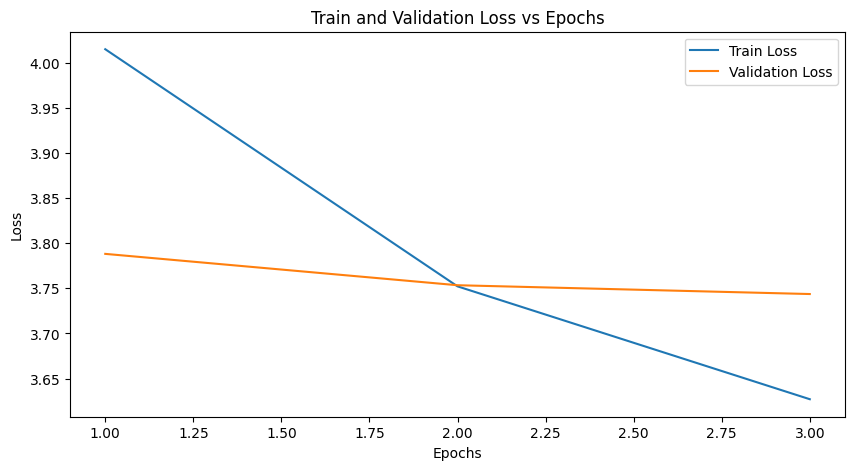

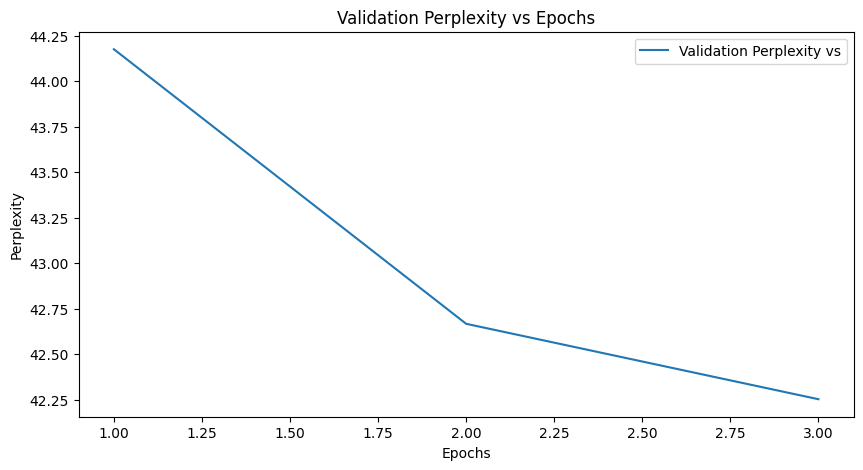

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, num_train_epochs+1)

# Plotting train loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs Epochs')
plt.legend()
plt.show()



# Plotting train perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, perplexity_list, label='Validation Perplexity vs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity vs Epochs')
plt.legend()
plt.show()

# Test the model

In [19]:
test_perplexity = perplexity_score(model, test_dataloader, 'cuda')
print(test_perplexity)

eval: 100%|██████████| 313/313 [02:01<00:00,  2.57it/s]

42.361354352070364


In [1]:
bleu_score = calculate_bleu_score(model, test_dataloader, 'cuda')
print(bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserW

In [ ]:
generate_story("He was born to be a killer")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"He was born to be a killer He tortured so cruel to say least <sep> Emma liked to sleep awake to smell smell of blood coming from his face Soft soft white and had a comforting aroma of fresh air All too often he struggled to cling onto his own skin soft soft soft boy she looked like more than old friends Never would he forget his dying mother with strong blonde hair matted her back and shambles of bloody face that always pain more than shock power < newline > < newline > Emma too small He only six She couldn't even walk made running difficult but usually happened to have good luck < newline > < newline > Somewhere deep within his lungs inside of his skull extracted by deep being of someone else's womb He looked down at her great eyes Their black colors his blue hair white skin His skull's filled with tiny hairs along edges of his lips looked like apples planted together There only tiny smile his face < newline > < newline > Emma shook her head as she came to stop behind her for an assi